Features in X: ['Age', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'DaysSinceSignup', 'NumWebPurchases', 'NumStorePurchases', 'NumDealsPurchases', 'TotalSpent', 'Education_Basic', 'Education_Graduation', 'Education_Master', 'Education_PhD', 'Marital_Status_Married', 'Marital_Status_Single', 'Marital_Status_Together', 'Marital_Status_Widow']

Model R²: 0.710, MSE: 36007.35

Feature Importance Table
             Feature  Importance
0             Income    0.557079
1  NumStorePurchases    0.095937
2    DaysSinceSignup    0.083487
4         TotalSpent    0.068754
3    NumWebPurchases    0.065806
5                Age    0.048856
6            Recency    0.039271
7      Education_PhD    0.023978
8  NumDealsPurchases    0.016833


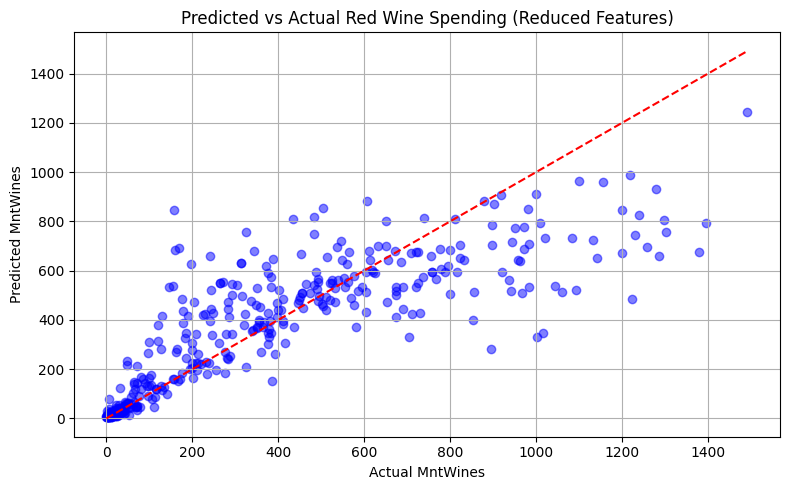

交叉验证 R² 分数： [0.75399212 0.67999371 0.70037029 0.66088003 0.66424143]
平均 R²：0.692


In [42]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

# === 预处理部分（略） ===
df = pd.read_csv('marketing_campaign_CLEANED.csv', sep=',')

# ---------- ① 解析 Dt_Customer 并生成天数字段 ----------
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')

# 以数据集中最晚日期为“今天”，也可改为 datetime(2025,1,1)
ref_date = df['Dt_Customer'].max()
df['DaysSinceSignup'] = (ref_date - df['Dt_Customer']).dt.days


df['Age'] = 2025 - df['Year_Birth']
df = df[df['Age'] <= 100]
df = df.dropna(subset=['Income'])
df = pd.get_dummies(df, columns=['Education', 'Marital_Status'], drop_first=True)
df['TotalSpent'] = df[[
    'MntFruits', 'MntMeatProducts', 'MntFishProducts',
    'MntSweetProducts', 'MntGoldProds'
]].sum(axis=1)
features = [
    'Age', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'DaysSinceSignup',
    'NumWebPurchases', 'NumStorePurchases', 'NumDealsPurchases',
    'TotalSpent'
] + [col for col in df.columns if col.startswith('Education_') or col.startswith('Marital_Status_')]
target = 'MntWines'
# 设置过滤阈值
Setting_Amount = 30  # 你可以改成 100、200 等

# 计算总消费（包括 MntWines）
df['TotalSpendingAll'] = df[[
    'MntWines', 'MntFruits', 'MntMeatProducts',
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'
]].sum(axis=1)

# 筛选出活跃客户（消费额大于 Setting_Amount）
df_active = df[df['TotalSpendingAll'] >= Setting_Amount].copy()
# 替代原本的 df --> df_active 后进行建模
X = df_active[features]
y = df_active[target]


# 假设你已经有了 X, y（模型用的原始特征与目标变量）
print("Features in X:", X.columns.tolist())      # 一眼查看是否含 'ID' 或 'Dt_Customer'

# 👉 第一步：用原始数据训练一次，提取 feature importance
rf_init = RandomForestRegressor(n_estimators=100, random_state=42)
rf_init.fit(X, y)

# 👉 第二步：按重要性筛选特征（可调节阈值）
importances = rf_init.feature_importances_
features_all = X.columns
coef_table = pd.DataFrame({
    "Feature": features_all,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# 设置阈值，只保留重要性 > 0.01 的特征
important_features = coef_table[coef_table['Importance'] > 0.01]['Feature'].tolist()
X_reduced = X[important_features]

# 👉 第三步：重新训练随机森林模型
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# 👉 第四步：评估模型性能
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"\nModel R²: {r2:.3f}, MSE: {mse:.2f}")

# 👉 第五步：输出新模型的特征重要性表
coef_reduced = pd.DataFrame({
    "Feature": X_reduced.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importance Table")
print(coef_reduced)

# 👉 第六步：画出预测 vs 实际散点图
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.xlabel("Actual MntWines")
plt.ylabel("Predicted MntWines")
plt.title("Predicted vs Actual Red Wine Spending (Reduced Features)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 👉 第七步：交叉验证
cv_scores = cross_val_score(rf_model, X_reduced, y, cv=5, scoring='r2')
print("交叉验证 R² 分数：", cv_scores)
print(f"平均 R²：{cv_scores.mean():.3f}")


In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

# 保持与你之前一致的训练 / 测试划分
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42
)

# 定义参数网格（适度即可）
param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
grid = GridSearchCV(
    rf, param_grid,
    cv=5,               # 5-fold 交叉验证
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best Parameter:", grid.best_params_)
print(f"Validator Set R²: {grid.best_score_:.3f}")

# 在留出的测试集上评估
y_pred = best_model.predict(X_test)
print(f"Test Set R²: {r2_score(y_test, y_pred):.3f}")
print(f"Test Set MSE: {mean_squared_error(y_test, y_pred):.2f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameter: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}
Validator Set R²: 0.676
Test Set R²: 0.715
Test Set MSE: 35343.14


C:\Users\Unico\AppData\Local\Temp\ipykernel_31636\2731838752.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="Blues_d")


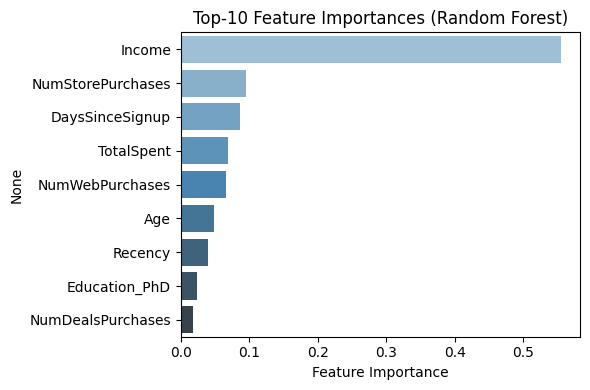

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# 取前 10 个最重要特征
importances = best_model.feature_importances_
feat_imp = pd.Series(importances, index=X_reduced.columns).sort_values(ascending=False)[:10]

plt.figure(figsize=(6,4))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="Blues_d")
plt.xlabel("Feature Importance")
plt.title("Top-10 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


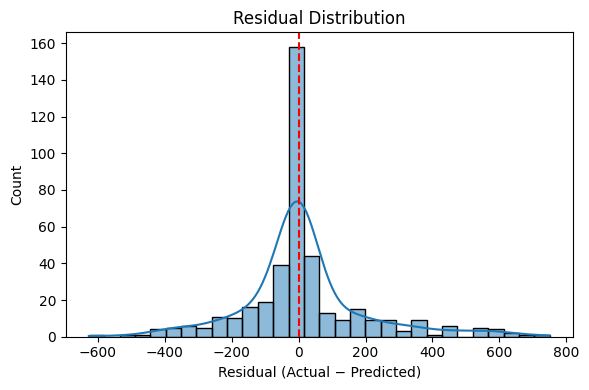

In [45]:
import numpy as np

residuals = y_test - y_pred

plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residual (Actual − Predicted)")
plt.title("Residual Distribution")
plt.tight_layout()
plt.show()
